## K Nearest Neighbours

In this latest version of the build your own model seires, I am going to attempt to build a K Nearest Neighbours model. My initial thoughts are that this should be fairly trivial but it will be interesting to find out.

First, we need to get the probabilities of a set of predictors equalling each class, in the form: 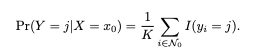
The tricky part will be defining the set of K closest predictors N0, and how you define 'close'. As usual I am following the guidance in the Introduction to Statistical Learning for Python by Gareth James et al. However, it does not provide an equation for the 'closest'. It would make sense to use the Euclidean distance for continuous variables, and a quick look online I can see most agree: 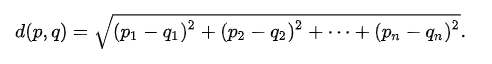
Again, we will use the Iris database, since it is well suited for this type of model.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
df = datasets.load_iris(as_frame=True)
X = df.data
y = df.target

To ensure the larger features don't have a larger impact on the desicion we will scale the data using a standard scaler. As is the theme of these articles we will do this ourself. To do this we simply recreate each feature as z = (x - u) / s, where u is the mean and s is the standard deviation of the feature.

In [112]:
X_standard = pd.DataFrame()
for column in X.columns:
    X_standard[column] = (X[column] - X[column].mean()) / np.array(X[column]).std()

Note we have used numpy to get the standard deviation, as it gives the biased standard deviation, which matches the SKLearn scaler which we will use when comparing models later, whereas pandas uses the unbiased standard deviation.

To get the model to work, let's simply use a dummy predictor x with 0 for each feature and arbitrarily choose K=5.

In [163]:
x = [0,0,0,0]
K = 5

Now, let's define a function that takes x and K and makes a prediction based on the K nearest neighbours algorithm.

In [127]:
def k_nearest_neighbours(x: list, K: int):
    euc_dis = np.sqrt((x[0]-X_standard.iloc[:,0])**2 + 
                      (x[1]-X_standard.iloc[:,1])**2 +
                      (x[2]-X_standard.iloc[:,2])**2 + 
                      (x[3]-X_standard.iloc[:,3])**2) # Calculate the euclidean distance for each predictor
    return y[euc_dis.nsmallest(n=K).index].mode().values[0] # Find the most common class for the K smallest euclidean distances

Here I have taken the indices of the K smallest Euclidean distances and applied them to our target variable y, and taken the mode of the classes that are remaining. This is essentially using uniform weights to the Euclidean distances. There is one glaring issue with the code that I have written, which is what happens if there are an equal number of classes in the K neighbours. The mode function would output two numbers, to which my code would pick up the first. Since these would be ordered by the smallest Euclidean distances then it would take the class with the single smallest Euclidean distance (of the classes with the joint highest number of neighbours). This seems a  somewhat logical choice to make when dealing with ties. Other options I would consider would be extending K until a majority is found or to switch to a distance weighted classification when ties occur.

In deciding which method to use I looked at what SKLearn does in such scenarios, while it is not clearly documented this stackechange shows that SK Learn actually functions the same way as my algorithm above: https://stats.stackexchange.com/questions/144718/how-does-scikit-learn-resolve-ties-in-the-knn-classification

As a result, I am hapy to stick with this method.

Let's see if that functions as expected:

In [128]:
k_nearest_neighbours(x,K)

1

Let's set up an SKLearn version of the model and see if we get the same prediction:

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(X_std,columns=df.data.columns)

In [111]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std,y)
pred = knn.predict(pd.DataFrame([x], columns=df.data.columns))
pred

array([1])

Yes, that matches. Now we need to expand the model to get predictions on a large number of inputs and see if it still matches the SKLearn model. First, let's create an array of standard normal samples that can be input into our model as scaled dummy data.

In [120]:
test = np.random.normal(size=[100,4])
test_df = pd.DataFrame(test, columns=df.data.columns)

We now need another function to iteratively call our K nearest neighbours function and log the output, to compare to the SKLearn results.

In [129]:
def k_iter(X: np.array, K: int):
    class_result = []
    for row in X:
        class_result.append(k_nearest_neighbours(x=row, K=K))
    return class_result

Now to make my predictions and SKLearn's predictions:

In [134]:
my_pred = k_iter(test,5)

In [135]:
sk_pred = knn.predict(test_df)

The easiest way to see if our model is functioning as expected is to create a classification report between our prediction and the SKLearn prediction.

In [164]:
from sklearn.metrics import classification_report
print(classification_report(sk_pred,my_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



Here we can see the models are predicting the same results.

Finally, let's see how our model performs on our training data. Note, we need to make a slight adjsutment to our k nearest neighbours function so that the predictor is not included in the neighbours results:

In [158]:
def k_nearest_neighbours(x: list, K: int):
    euc_dis = np.sqrt((x[0]-X_standard.iloc[:,0])**2 + 
                      (x[1]-X_standard.iloc[:,1])**2 +
                      (x[2]-X_standard.iloc[:,2])**2 + 
                      (x[3]-X_standard.iloc[:,3])**2) # Calculate the euclidean distance for each predictor
    return y[euc_dis.nsmallest(n=K+1).index[1:K+1]].mode().values[0] # Find the most common class for the K smallest euclidean distances, not including the closest, which will be the predictor itself

def k_iter(X: np.array, K: int):
    class_result = []
    for row in X:
        class_result.append(k_nearest_neighbours(x=row, K=K))
    return class_result

In [159]:
pred = k_iter(X_standard.values,5)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.92      0.92      0.92        50
           2       0.92      0.92      0.92        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



Unsurprisingly the model performs well. But let's see if we can make it even better. We can iterate through a number of Ks and plot the error rate. 

In [160]:
error_rate = []
for i in range(1,40):    
    pred_i = pred = k_iter(X_standard.values,i)
    error_rate.append(np.mean(pred_i != y))

Text(0, 0.5, 'Error rate')

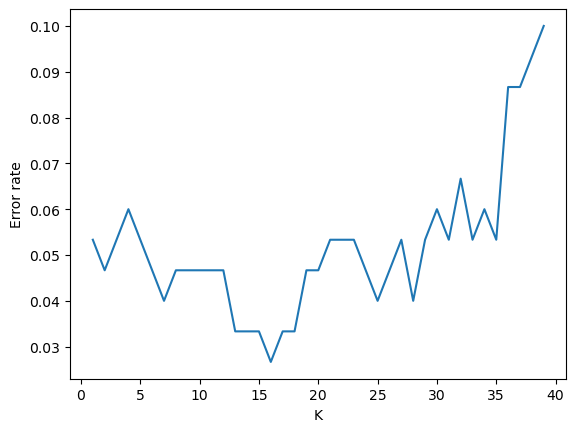

In [161]:
plt = sns.lineplot(x=range(1,40), y=error_rate)
plt.set_xlabel("K")
plt.set_ylabel("Error rate")

As we can see the error rate reduces to a minimum between K = 16.

In [162]:
pred = k_iter(X_standard.values,16)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.94      0.98      0.96        50
           2       0.98      0.94      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



We'll leave it there for K nearest neighbours. A simple but effective model that can be implemented with ease.